Dataset original con valores nulos:
   binary_feature  numeric_feature1  numeric_feature2 categorical_feature  \
0             1.0                10               NaN             manzana   
1             0.0                 3               3.0                pera   
2             NaN                 6               2.0             naranja   
3             1.0                 1               NaN                piña   
4             0.0                 7               4.0                 NaN   

   target  
0       1  
1       0  
2       1  
3       0  
4       1  
Después de imputar la columna binaria con KNN:
   binary_feature  numeric_feature1  numeric_feature2 categorical_feature  \
0             1.0                10               NaN             manzana   
1             0.0                 3               3.0                pera   
2             0.5                 6               2.0             naranja   
3             1.0                 1               NaN                piña 

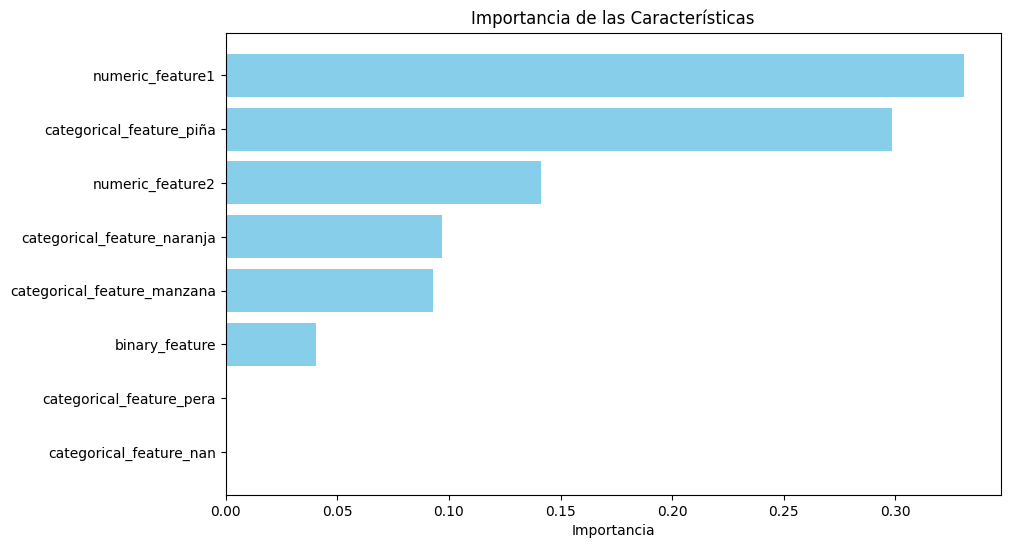

Después de revertir el One-Hot Encoding:
   binary_feature  numeric_feature1  numeric_feature2  target  \
0             1.0              10.0               3.0     1.0   
1             0.0               3.0               3.0     0.0   
2             0.5               6.0               2.0     1.0   
3             1.0               1.0               3.0     0.0   
4             0.0               7.0               4.0     1.0   

  categorical_feature  
0             manzana  
1                pera  
2             naranja  
3                piña  
4                 NaN  


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Crear un DataFrame de ejemplo con diferentes tipos de datos
data = {
    'binary_feature': [1, 0, np.nan, 1, 0],
    'numeric_feature1': [10, 3, 6, 1, 7],
    'numeric_feature2': [np.nan, 3, 2, np.nan, 4],
    'categorical_feature': ['manzana', 'pera', 'naranja', 'piña', np.nan],  # Aseguramos la misma longitud
    'target': [1, 0, 1, 0, 1]
}
df = pd.DataFrame(data)
print("Dataset original con valores nulos:")
print(df)

# Imputar valores nulos en características binarias usando KNN
knn_imputer = KNNImputer(n_neighbors=2)
df[['binary_feature']] = knn_imputer.fit_transform(df[['binary_feature']])
print("Después de imputar la columna binaria con KNN:")
print(df)

# Imputar valores nulos en características numéricas usando interpolación
df['numeric_feature2'] = df['numeric_feature2'].interpolate()
print("Después de imputar la columna numérica con interpolación:")
print(df)

# One-Hot Encoding para características categóricas
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoded = ohe.fit_transform(df[['categorical_feature']])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(['categorical_feature']))

# Combinar con el DataFrame original sin la columna categórica original
df_combined = pd.concat([df.drop(columns=['categorical_feature']), cat_encoded_df], axis=1)

# Imputar valores nulos en la característica categórica usando KNN
df_combined = pd.DataFrame(knn_imputer.fit_transform(df_combined), columns=df_combined.columns)
print("Después de imputar la columna categórica con KNN:")
print(df_combined)

# Mantener las características categóricas en formato codificado para el modelo
df_final = df_combined  # No revertimos el One-Hot Encoding para el modelo

# Separar características y la variable objetivo
X = df_final.drop(columns=['target'])
y = df_final['target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Obtener las importancias de las características
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar las importancias de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()

# Revertir One-Hot Encoding a la forma original
encoded_cols = ohe.get_feature_names_out(['categorical_feature'])
decoded_categories = ohe.inverse_transform(df_combined[encoded_cols])
df_combined['categorical_feature'] = pd.Series(decoded_categories.flatten())
df_reverted = df_combined.drop(columns=encoded_cols)
print("Después de revertir el One-Hot Encoding:")
print(df_reverted)
